# Insert Data


## Intro


_Developer Note:_ if you may make a PR in the future, be sure to copy this
notebook, and use the `gitignore` prefix `temp` to avoid future conflicts.

This is one notebook in a multi-part series on Spyglass.

- To set up your Spyglass environment and database, see
  [the Setup notebook](./00_Setup.ipynb)
- For additional info on DataJoint syntax, including table definitions and
  inserts, see
  [these additional tutorials](https://github.com/datajoint/datajoint-tutorials)

Let's start by importing the `spyglass` package, along with a few others.


In [1]:
import os
import datajoint as dj

# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
dj.config.load("dj_local_conf.json")  # load config for database connection info

# ignore datajoint+jupyter async warnings
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)
warnings.simplefilter("ignore", category=UserWarning)

# spyglass.common has the most frequently used tables
import spyglass.common as sgc

# spyglass.data_import has tools for inserting NWB files into the database
import spyglass.data_import as sgi

[2024-01-29 16:24:30,933][INFO]: Connecting root@localhost:3309
[2024-01-29 16:24:30,942][INFO]: Connected root@localhost:3309


## Visualizing the database


Datajoint enables users to use Python to build and interact with a _Relational Database_. In a [Relational Data Model](https://www.smartsheet.com/relational-database-modeling), each table is an object that can reference
information in other tables to avoid redundancy.

DataJoint has built-in tools for generating/saving a _Diagram_ of the
relationships between tables.
[This page](https://datajoint.com/docs/core/datajoint-python/0.14/design/diagrams/) describes the notation used.

Polygons are tables, colors reference
[table type](https://datajoint.com/docs/core/datajoint-python/0.14/design/tables/tiers/):

- Green rectangle: tables whose entries are entered _manually_.
- Blue oval: tables whose entries are _imported_ from external files
  (e.g. NWB file).
- Red circle: tables whose entries are _computed_ from entries of other tables.
- No shape (only text): tables whose entries are _part_ of the table upstream

Lines are _dependencies_ between tables. An _upstream_ table is connected to a
_downstream_ table via _inheritance_ of the
[_primary key_](https://docs.datajoint.org/python/definition/07-Primary-Key.html).
This is the set of attributes (i.e., column names) used to uniquely define an
entry (i.e., a row)

- Bold lines: the upstream primary key is the sole downstream primary key
- Solid lines: the upstream table as part of the downstream primary key
- Dashed lines: the primary key of upstream table as non-primary key


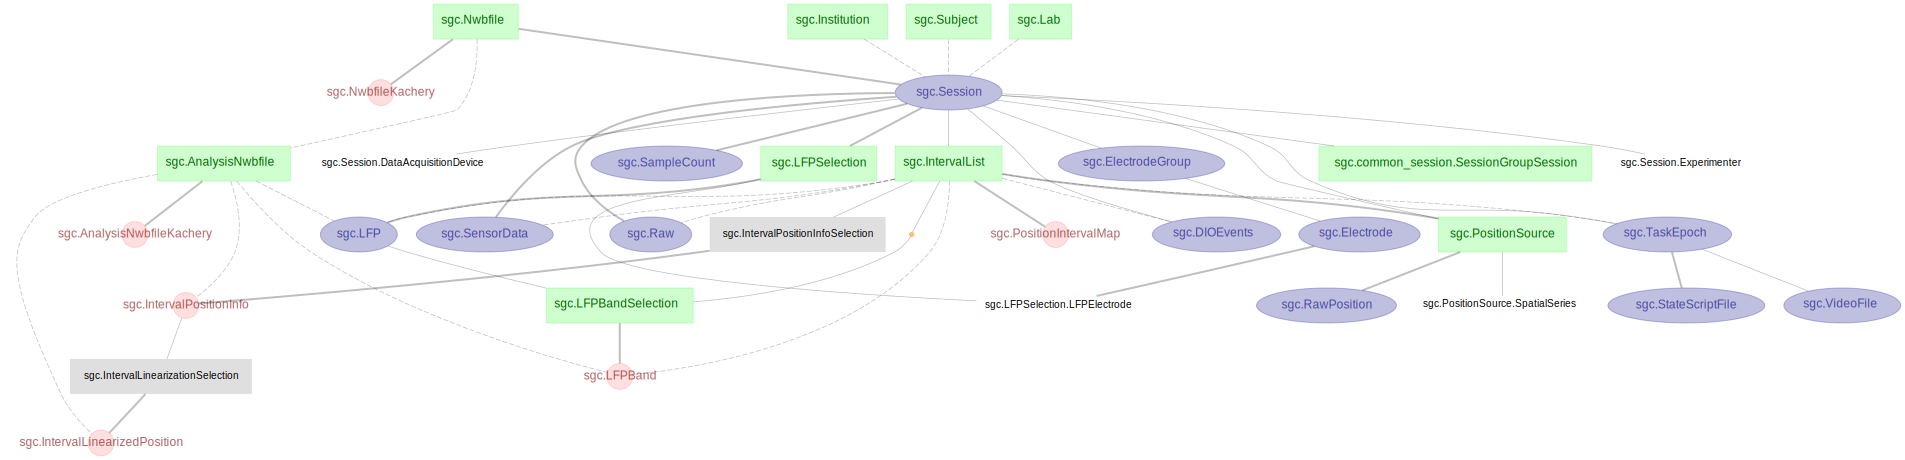

In [2]:
# Draw tables that are two levels below and one level above Session
dj.Diagram(sgc.Session) - 1 + 2

By adding diagrams together, of adding and subtracting levels, we can visualize
key parts of Spyglass.

_Note:_ Notice the _Selection_ tables. This is a design pattern that selects a
subset of upstream items for further processing. In some cases, these also pair
the selected data with processing parameters.


## Example data


After exploring the pipeline's structure, we'll now grab some example data.
Spyglass will assume that the data is a neural recording with relevant auxiliary
in NWB.

We offer a few examples:

- `minirec20230622.nwb`, .3 GB: minimal recording,
  [Link](https://ucsf.box.com/s/k3sgql6z475oia848q1rgms4zdh4rkjn)
- `mediumnwb20230802.nwb`, 32 GB: full-featured dataset,
  [Link](https://ucsf.box.com/s/2qbhxghzpttfam4b7q7j8eg0qkut0opa)
- `montague20200802.nwb`, 8 GB: full experimental recording,
  [Link](https://ucsf.box.com/s/26je2eytjpqepyznwpm92020ztjuaomb)
- For those in the UCSF network, these and many others on `/stelmo/nwb/raw`

If you are connected to the Frank lab database, please rename any downloaded
files (e.g., `example20200101_yourname.nwb`) to avoid naming collisions, as the
file name acts as the primary key across key tables.


In [2]:
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

# Define the name of the file that you copied and renamed
nwb_file_name = "minirec20230622.nwb"
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

Spyglass will create a copy with this name.


In [4]:
nwb_copy_file_name

'minirec20230622_.nwb'

## Basic Inserts: Lab Team


Let's start small by inserting personnel information.

The `LabMember` table lists all lab members, with an additional part table for
`LabMemberInfo`. This holds Google account and DataJoint username info for each
member, for authentication purposes.

We can insert lab member information using the NWB file `experimenter` field
as follows...


In [5]:
# take a look at the lab members
sgc.LabMember.insert_from_nwbfile(nwb_file_name)

Please add the Google user ID for Firstname Lastname in the LabMember.LabMemberInfo table to help manage permissions.
Please add the Google user ID for Firstname2 Lastname2 in the LabMember.LabMemberInfo table to help manage permissions.


We can [insert](https://datajoint.com/docs/core/datajoint-python/0.14/manipulation/insert/)
into `LabMemberInfo` directly with a list of lists that reflect the order of
the fields present in the table. See
[this notebook](https://github.com/datajoint/datajoint-tutorials/blob/main/00-Getting_Started/01-DataJoint%20Basics%20-%20Interactive.ipynb)
for examples of inserting with `dicts`.


In [6]:
sgc.LabMember.LabMemberInfo.insert(
    [  # Full name, Google email address, DataJoint username, admin
        ["Firstname Lastname", "example1@gmail.com", "example1", 0],
        ["Firstname2 Lastname2", "example2@gmail.com", "example2", 0],
    ],
    skip_duplicates=True,
)
sgc.LabMember.LabMemberInfo()

lab_member_name,google_user_name used for permission to curate,datajoint_user_name used for permission to delete entries
Firstname Lastname,example1@gmail.com,example1
Firstname2 Lastname2,example2@gmail.com,example2


A `LabTeam` is a set of lab members who own a set of NWB files and the
associated information in the database. This is often a subgroup that
collaborates on the same projects. Data is associated with a given team,
granting members analysis (e.g., curation) and deletion (coming soon)
privileges.


In [7]:
team_name = "My Team"
sgc.LabTeam().create_new_team(
    team_name=team_name,  # Should be unique
    team_members=["Firstname Lastname", "Firstname2 Lastname2"],
    team_description="test",  # Optional
)

By default, each member is part of their own team. We can see all teams and
members by looking at the
[part table](https://datajoint.com/docs/core/datajoint-python/0.14/design/tables/master-part/)
`LabTeam.LabTeamMember`.


In [8]:
sgc.LabTeam.LabTeamMember()

team_name,lab_member_name
Firstname Lastname,Firstname Lastname
My Team,Firstname Lastname
Firstname2 Lastname2,Firstname2 Lastname2
My Team,Firstname2 Lastname2


In general, we can insert into any table in this say, by supplying 
a dictionary (or list of dictionaries) with all the fields mentioned in 
`Table.heading.names` so long as the data types match what is described in
`Table.heading`

```python
Table.insert1({'a': 1, 'b': 'other'}) # only one entry
Table.insert([{'a':1, 'b': 'other'}, {'a':1, 'b': 'next'}]) # multiple
```

For example ...

In [ ]:
sgc.ProbeType.insert1(
    {
        "probe_type": "128c-4s6mm6cm-15um-26um-sl",
        "probe_description": "A Livermore flexible probe with 128 channels ...",
        "manufacturer": "Lawrence Livermore National Lab",
        "num_shanks": 4,
    },
    skip_duplicates=True,
)

The `skip_duplicates` flag tells DataJoint not to raise an error if the data
is already in the table. This should only be used in special cases.

## Inserting from NWB


`spyglass.data_import.insert_sessions` helps take the many fields of data
present in an NWB file and insert them into various tables across Spyglass. If
the NWB file is properly composed, this includes...

- the experimenter (replicating part of the process above)
- animal behavior (e.g. video recording of position)
- neural activity (extracellular recording of multiple brain areas)
- etc.

_Notes:_ this may take time as Spyglass creates the copy. You may see a prompt
about inserting device information.

By default, the session insert process is error permissive. It will log an
error and continue attempts across various tables. You have two options you can
toggle to adjust this.

- `rollback_on_fail`: Default False. If True, errors will still be logged for
  all tables and, if any are registered, the `Nwbfile` entry will be deleted.
  This is helpful for knowing why your file failed, and making it easy to retry.
- `raise_err`: Default False. If True, errors will not be logged and will
  instead be raised. This is useful for debugging and exploring the error stack.
  The end result may be that some tables may still have entries from this file
  that will need to be manually deleted after a failed attempt. 'transactions'
  are used where possible to rollback sibling tables, but child table errors
  will still leave entries from parent tables.


In [3]:
sgi.insert_sessions(nwb_file_name, rollback_on_fail=False, raise_err=False)

Creating a copy of NWB file minirec20230622.nwb with link to raw ephys data: minirec20230622_.nwb
Populate Session...
No config found at file path /home/cb/wrk/data/raw/minirec20230622_spyglass_config.yaml
Institution...
Lab...
LabMember...
Please add the Google user ID for Firstname2 Lastname2 in the LabMember.LabMemberInfo table to help manage permissions.
Subject...
Populate CameraDevice...
Inserted camera devices ['test camera 1']

Populate Probe...
Probe ID '128c-4s6mm6cm-15um-26um-sl' already exists in the database. Spyglass will use that and not create a new Probe, Shanks, or Electrodes.
Inserted probes {'128c-4s6mm6cm-15um-26um-sl'}

Skipping Apparatus for now...
IntervalList...
LabMember with name lastname, firstname does not exist. Cannot link Session with LabMember in Session.Experimenter.
LabMember with name lastname2, firstname2 does not exist. Cannot link Session with LabMember in Session.Experimenter.
Populate ElectrodeGroup...
Populate Electrode...
No config found at fi

## Inspecting the data


To look at data, we can
[query](https://datajoint.com/docs/core/datajoint-python/0.14/query/principles/)
a table with `Table()` syntax.


In [11]:
sgc.Lab()

lab_name
Loren Frank Lab


The `Session` table has considerably more fields


In [12]:
sgc.Session.heading.names

['nwb_file_name',
 'subject_id',
 'institution_name',
 'lab_name',
 'session_id',
 'session_description',
 'session_start_time',
 'timestamps_reference_time',
 'experiment_description']

But a short primary key


In [13]:
sgc.Session.heading.primary_key

['nwb_file_name']

The primary key is shown in bold in the html


In [14]:
sgc.Session()

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
minirec20230622_.nwb,54321,UCSF,Loren Frank Lab,12345,test yaml insertion,2023-06-22 15:59:58,1970-01-01 00:00:00,Test Conversion


Text only interfaces designate the primary key fields with `*`


In [15]:
print(sgc.Session())

*nwb_file_name subject_id     institution_na lab_name       session_id     session_descri session_start_ timestamps_ref experiment_des
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
minirec2023062 54321          UCSF           Loren Frank La 12345          test yaml inse 2023-06-22 15: 1970-01-01 00: Test Conversio
 (Total: 1)



To see a the
[table definition](https://datajoint.com/docs/core/datajoint-python/0.14/design/tables/declare/),
including
[data types](https://datajoint.com/docs/core/datajoint-python/0.14/design/tables/attributes/),
use `describe`.

- `---` separates the primary key
- `:` are used to separate field name from data type
- `#` can be used to add comments to a field


In [16]:
from pprint import pprint  # adds line breaks

pprint(sgc.Session.describe())

('# Table for holding experimental sessions.\n'
 '-> sgc.Nwbfile\n'
 '---\n'
 '-> [nullable] sgc.Subject\n'
 '-> [nullable] sgc.Institution\n'
 '-> [nullable] sgc.Lab\n'
 'session_id=null      : varchar(200)                 \n'
 'session_description  : varchar(2000)                \n'
 'session_start_time   : datetime                     \n'
 'timestamps_reference_time : datetime                     \n'
 'experiment_description=null : varchar(2000)                \n')


To look at specific entries in a table, we can use the `&`
[operator](https://datajoint.com/docs/core/datajoint-python/0.14/query/operators/).
Below, we _restrict_ based on a `dict`, but you can also use a
[string](https://datajoint.com/docs/core/datajoint-python/0.14/query/restrict/#restriction-by-a-string).


In [17]:
sgc.Session & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
minirec20230622_.nwb,54321,UCSF,Loren Frank Lab,12345,test yaml insertion,2023-06-22 15:59:58,1970-01-01 00:00:00,Test Conversion


`Raw` is connected to `Session` with a bold line, so it has the same primary key.


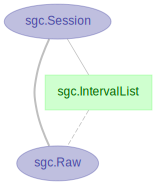

In [18]:
dj.Diagram(sgc.Session) + dj.Diagram(sgc.Raw)

In [19]:
sgc.Raw & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,raw_object_id the NWB object ID for loading this object from the file,"sampling_rate Sampling rate calculated from data, in Hz",comments,description
minirec20230622_.nwb,raw data valid times,4e756642-9203-4f00-b9d0-0e9747c14493,30000.0,No comment,Recording of extracellular voltage


`IntervalList` is connected to `Session` with a solid line because it has
additional primary key attributes. Here, you need to know both `nwb_file_name`
and `interval_list_name` to uniquely identify an entry.


In [20]:
# join/split condenses long spaces before field comments
pprint("".join(sgc.IntervalList.describe().split("  ")))

('# Time intervals used for analysis\n'
 '-> sgc.Session\n'
 'interval_list_name : varchar(200) # descriptive name of this interval list\n'
 '---\n'
 'valid_times: longblob # numpy array with start and end times for each '
 'interval\n')


In [21]:
sgc.IntervalList & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval
minirec20230622_.nwb,01_s1,=BLOB=
minirec20230622_.nwb,02_s2,=BLOB=
minirec20230622_.nwb,pos 0 valid times,=BLOB=
minirec20230622_.nwb,pos 1 valid times,=BLOB=
minirec20230622_.nwb,raw data valid times,=BLOB=


Raw [data types](https://datajoint.com/docs/core/datajoint-python/0.14/design/tables/attributes/) like `valid_times` are shown as `=BLOB=`. We can inspect
these with [`fetch`](https://datajoint.com/docs/core/datajoint-python/0.14/query/fetch/)

_Note:_ like `insert`/`insert1`, `fetch` can be uses as `fetch1` to raise an
error when many (or no) entries are retrieved. To limit to one entry when there
may be many, use `query.fetch(limit=1)[0]`


In [22]:
(
    sgc.IntervalList
    & {
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": "pos 1 valid times",
    }
).fetch1("valid_times")

array([[1.68747483e+09, 1.68747484e+09]])

In DataJoint [operators](https://datajoint.com/docs/core/datajoint-python/0.14/query/restrict/#restriction-by-a-string),
`&` selects by a condition and `-` removes a condition.


In [23]:
(
    (
        (sgc.IntervalList & {"nwb_file_name": nwb_copy_file_name})
        - {"interval_list_name": "pos 1 valid times"}
    )
    - {"interval_list_name": "pos 2 valid times"}
).fetch("interval_list_name")

array(['01_s1', '02_s2', 'pos 0 valid times', 'raw data valid times'],
      dtype=object)

`IntervalList` has an additional secondary key `pipeline` which can describe the origin of the data.
Because it is a _secondary_ key, it is not required to uniquely identify an entry.
Current values for this key from spyglass pipelines are:

| pipeline                  | Source                                              |
| ------------------------- | --------------------------------------------------- |
| position                  | sg.common.PositionSource                            |
| lfp_v0                    | sg.common.LFP                                       |
| lfp_v1                    | sg.lfp.v1.LFPV1                                     |
| lfp_band                  | sg.common.LFPBand,<br> sg.lfp.analysis.v1.LFPBandV1 |
| lfp_artifact              | sg.lfp.v1.LFPArtifactDetection                      |
| spikesorting_artifact_v0  | sg.spikesorting.ArtifactDetection                   |
| spikesorting_artifact_v1  | sg.spikesorting.v1.ArtifactDetection                |
| spikesorting_recording_v0 | sg.spikesorting.SpikeSortingRecording               |
| spikesorting_recording_v1 | sg.spikesorting.v1.SpikeSortingRecording            |


## Deleting data


Another neat feature of DataJoint is that it automatically maintains
[data integrity](https://datajoint.com/docs/core/datajoint-python/0.14/design/integrity/)
with _cascading deletes_. For example, if we delete our `Session` entry, all
associated downstream entries are also deleted (e.g. `Raw`, `IntervalList`).

_Note_: The deletion process can be complicated by
[Merge Tables](https://lorenfranklab.github.io/spyglass/0.4/misc/merge_tables/)
when the entry is referenced by a part table. To demo deletion in these cases,
run the hidden code below.

<details>
<summary>Quick Merge Insert</summary>

```python
import spyglass.lfp as lfp

sgc.FirFilterParameters().create_standard_filters()
lfp.lfp_electrode.LFPElectrodeGroup.create_lfp_electrode_group(
    nwb_file_name=nwb_copy_file_name,
    group_name="test",
    electrode_list=[0],
)
lfp_key = {
    "nwb_file_name": nwb_copy_file_name,
    "lfp_electrode_group_name": "test",
    "target_interval_list_name": "01_s1",
    "filter_name": "LFP 0-400 Hz",
    "filter_sampling_rate": 30_000,
}
lfp.v1.LFPSelection.insert1(lfp_key, skip_duplicates=True)
lfp.v1.LFPV1().populate(lfp_key)
```

</details>
<details>
<summary>Deleting Merge Entries</summary>

```python
nwbfile = sgc.Nwbfile()

(nwbfile & {"nwb_file_name": nwb_copy_file_name}).delete_downstream_parts(
    dry_run=False, # True will show Merge Table entries that would be deleted
)
```

Please see the [next notebook](./03_Merge_Tables.ipynb) for a more detailed
explanation.

</details>


In [24]:
session_entry = sgc.Session & {"nwb_file_name": nwb_copy_file_name}
session_entry

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
minirec20230622_.nwb,54321,UCSF,Loren Frank Lab,12345,test yaml insertion,2023-06-22 15:59:58,1970-01-01 00:00:00,Test Conversion


`Session.Experimenter` is used for permissions checks when deleting. The
session will need to have an experimenter in order avoid an error being
raised during this check.


In [ ]:
sess_key = (sgc.Session & {"nwb_file_name": nwb_copy_file_name}).fetch(
    "KEY", as_dict=True
)[0]
exp_key = (sgc.LabMember).fetch("KEY", as_dict=True)[0]
sgc.Session.Experimenter.insert1(
    dict(**sess_key, **exp_key), skip_duplicates=True
)

Even with the experimenter specified, there are still delete protections
in place. To see an example, uncomment the cell below.


In [ ]:
# session_entry.delete()

To delete, you'll need to share a team with the session experimenter.


In [ ]:
your_name = "YourFirst YourLast"
parts = your_name.split(" ")
sgc.LabMember.insert1([your_name, parts[0], parts[1]])
sgc.LabMember.LabMemberInfo.insert1(
    [your_name, "your_gmail", dj.config["database.user"], 0]
)
sgc.LabTeam.LabTeamMember.insert1([team_name, your_name])

By default, DataJoint is cautious about deletes and will prompt before deleting.
To delete, uncomment the cell below and respond `yes` in the prompt.


In [26]:
# session_entry.delete()

[2023-09-28 08:29:15,814][INFO]: Deleting 4 rows from `common_behav`.`_raw_position__pos_object`
INFO:datajoint:Deleting 4 rows from `common_behav`.`_raw_position__pos_object`
[2023-09-28 08:29:15,822][INFO]: Deleting 2 rows from `common_behav`.`_raw_position`
INFO:datajoint:Deleting 2 rows from `common_behav`.`_raw_position`
[2023-09-28 08:29:15,834][INFO]: Deleting 4 rows from `common_behav`.`position_source__spatial_series`
INFO:datajoint:Deleting 4 rows from `common_behav`.`position_source__spatial_series`
[2023-09-28 08:29:15,841][INFO]: Deleting 2 rows from `common_behav`.`position_source`
INFO:datajoint:Deleting 2 rows from `common_behav`.`position_source`
[2023-09-28 08:29:15,851][INFO]: Deleting 7 rows from `common_dio`.`_d_i_o_events`
INFO:datajoint:Deleting 7 rows from `common_dio`.`_d_i_o_events`
[2023-09-28 08:29:15,871][INFO]: Deleting 128 rows from `common_ephys`.`_electrode`
INFO:datajoint:Deleting 128 rows from `common_ephys`.`_electrode`
[2023-09-28 08:29:15,879][INFO

1

We can check that delete worked, both for `Session` and `IntervalList`


In [27]:
sgc.Session & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description


In [28]:
sgc.IntervalList & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval


`delete` is useful for re-running something. Editing entries is possible, but
discouraged because it can lead to
[integrity](https://datajoint.com/docs/core/datajoint-python/0.14/design/integrity/)
issues. Instead, re-enter and let the automation handle the rest.

Spyglass falls short, however, in that deleting from `Session` doesn't also
delete the associated entry in `Nwbfile`, which has to be removed separately
(for now). This table offers a `cleanup` method to remove the added files (with
the `delete_files` argument as `True`).

_Note:_ this also applies to deleting files from `AnalysisNwbfile` table.


In [53]:
# Uncomment to delete
# (sgc.Nwbfile & {"nwb_file_name": nwb_copy_file_name}).delete()

[2023-07-18 19:01:15,343][INFO]: Deleting 1 rows from `common_nwbfile`.`nwbfile`
INFO:datajoint:Deleting 1 rows from `common_nwbfile`.`nwbfile`
[2023-07-18 19:01:17,130][INFO]: Deletes committed.
INFO:datajoint:Deletes committed.


1

Note that the file (ends with `_.nwb`) has not been deleted, even if the entry
was deleted above.


In [ ]:
!ls $SPYGLASS_BASE_DIR/raw

minirec20230622.nwb
minirec20230622_.nwb
montague20200802_tutorial.nwb
montague20200802_tutorial_.nwb
montague20200802_tutorial__.nwb
sub-despereaux_ses-despereaux-08_behavior+ecephys_trim.nwb
sub-despereaux_ses-despereaux-08_behavior+ecephys_trim_.nwb
tonks20211103_.nwb


We can clean these files with the `cleanup` method


In [55]:
sgc.Nwbfile().cleanup(delete_files=True)

100%|██████████| 1/1 [00:00<00:00, 304.24it/s]


In [56]:
!ls $SPYGLASS_BASE_DIR/raw

minirec20230622.nwb
montague20200802_tutorial.nwb
montague20200802_tutorial_.nwb
montague20200802_tutorial__.nwb
sub-despereaux_ses-despereaux-08_behavior+ecephys_trim.nwb
sub-despereaux_ses-despereaux-08_behavior+ecephys_trim_.nwb
tonks20211103_.nwb


## YAML Inserts

The following step is an optional feature, and not required for the remaining
notebooks.

Not every NWB file has all the information required by Spyglass. For example,
many NWB files do not contain any information about the `DataAcquisitionDevice`
or `Probe` because NWB does not yet have an official standard for specifying
them. Or, information in the NWB file may need correcting. For example,
the NWB file specifies the lab name as the "Loren Frank Lab", but your lab table expects "Frank Lab".

Manual inserts can either be done on tables directly (e.g., 
`Table.insert1(my_dict)`), or done in batch with `yaml` files. This is done in
two steps: 

1. Generate data to be entered.
2. Associate data with one or more NWB files.


### Batch Insert

First, Spyglass will check for an `entries.yaml` file at the base directory
(see [Setup](./00_Setup.ipynb)) and run all corresponding inserts. 
This is a great place to define entries that the database should auto-insert
prior to ingesting any NWB files. An example can be found in
`examples/config_yaml/entries.yaml`. It has the following structure:

```yaml
TableName:
    - TableEntry1Field1: Value

TableEntry1Field2:
    - TableEntry2Field1: Value

TableEntry2Field2: Value
```

For example,

```yaml
ProbeType:
    - probe_type: 128c-4s6mm6cm-15um-26um-sl
    probe_description: A Livermore flexible probe with 128 channels, 4 shanks, 
        6 mm shank length, 6 cm ribbon length. 15 um contact diameter, 26 um 
        center-to-center distance (pitch), single-line configuration.
    manufacturer: Lawrence Livermore National Lab
    num_shanks: 4
```

Using a YAML file over data stored in Python scripts helps maintain records
of data entries in a human-readable file. For ways to share a state of the
database, see our [export tutorial](./05_Export.ipynb).


### Pairing with NWBs

Next, we'll create a _configuration file_ to override values in a given NWB
(e.g., "Loren Frank Lab" -> "Frank Lab"). This must be done in the same
directory as the NWB file that it configures and have the following naming
convention: `<name_of_nwb_file>_spyglass_config.yaml`. This file is then read by
Spyglass when calling `insert_session` on the associated NWB file.

An example of this can be found at
`examples/config_yaml/​​sub-AppleBottom_ses-AppleBottom-DY20-g3_behavior+ecephys_spyglass_config.yaml`.

This file is associated with the NWB file
`sub-AppleBottom_ses-AppleBottom-DY20-g3_behavior+ecephys.nwb`.

This is the general format for the config entry:

```yaml
TableName:
  - primary_key1: value1
```

For example:

```yaml
Lab:
  - lab_name: Frank Lab
DataAcquisitionDevice:
  - data_acquisition_device_name: Neuropixels Recording Device
```

In this example, the NWB file that corresponds to this config YAML will become
associated with the Lab primary key 'Frank Lab' and the DataAcquisitionDevice
with primary key 'Neuropixels Recording Device'. This entry must already exist.

### Example Ingestion with Real Data

For this example, you will need to download the 5 GB NWB file 
`sub-JDS-NFN-AM2_behavior+ecephys.nwb`
from dandiset 000447 here: 
https://dandiarchive.org/dandiset/000447/0.230316.2133/files?location=sub-JDS-NFN-AM2&page=1

Click the download arrow button to download the file to your computer. Add it to
 the folder containing your raw NWB data to be ingested into Spyglass.

This file does not specify a data acquisition device. Let's say that the
data was collected from a SpikeGadgets system with an Intan amplifier. This
matches an existing entry in the `DataAcquisitionDevice` table with name
"data_acq_device0". We will create a configuration YAML file to associate
this entry with the NWB file.

If you are connected to the Frank lab database, please rename any downloaded
files (e.g., `example20200101_yourname.nwb`) to avoid naming collisions, as the
file name acts as the primary key across key tables.

In [ ]:
nwb_file_name = "sub-JDS-NFN-AM2_behavior+ecephys_rly.nwb"

In [ ]:
# this configuration yaml file should be placed next to the downloaded NWB file
yaml_config_path = "sub-JDS-NFN-AM2_behavior+ecephys_rly_spyglass_config.yaml"
with open(yaml_config_path, "w") as config_file:
    lines = [
        "DataAcquisitionDevice",
        "- data_acquisition_device_name: data_acq_device0",
    ]
    config_file.writelines(line + "\n" for line in lines)

Then call `insert_sessions` as usual.

In [ ]:
import spyglass.data_import as sgi

sgi.insert_sessions(nwb_file_name)

Confirm the session was inserted with the correct `DataAcquisitionDevice`

In [ ]:
import spyglass.common as sgc
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

sgc.Session.DataAcquisitionDevice & {"nwb_file_name": nwb_copy_file_name}

## Up Next


In the [next notebook](./02_Data_Sync.ipynb), we'll explore tools for syncing.
